# **Machine Learning - An Interdisciplinary Introduction**

# **Exercise sheet 9**

## Exercise I: Toxicity of molecules

## Part A: Preparations

Run the following code to import some tools.

In [ ]:
import numpy as np
import pandas as pd
from collections import OrderedDict
from itertools import chain
!pip install rdkit-pypi -qqq
from rdkit import Chem
from rdkit.Chem import Draw
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

     |████████████████████████████████| 22.7 MB 70.9 MB/s 


---

In this exercise we will study the toxicity of molecules.
Molecules will be described using the simplified molecular input line entry system (SMILES). This system allows to describe the structure of chemical species in the form of a line notation, making it suited for a machine learning approach. 

---

**The basic rules for SMILES are:**

* Atom types are represented by their atomic symbols, upper case letters represent aliphatic atoms, lower case letters represented aromatic atoms, hydrogens are often stripped away, since those can be inferred from atom type and connectivity.

* Bonds are only represented if needed:

 $\text{-}$ : single bond (CC and C-C are the same, since single bonds are used by default)

 = : double bond (C=C-C=C and cccc are the same)
 
 $\#$ : triple bond

* Ring opening and closures are represented with numbers: 
 
 c1ccccc1 - benzene

* Substituents leaving a chain or ring are represented with brackets:

 c1cc(C)ccc1 - methyl-substituted benzene.

 CC(F)(Br)Cl - ethane substituted with fluorine, chlorine and bromine

(More detailed rules, not necessary for our exercise, can be found here: https://www.daylight.com/dayhtml/doc/theory/theory.smiles.html)

---

**1a)** With the following commands one can draw a 2d-representation of the molecule using its SMILE representation. Experiment with them to understand how SMILES work.

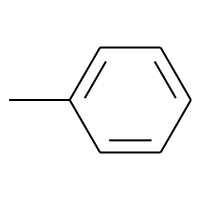

In [ ]:
m=Chem.MolFromSmiles('c1cc(C)ccc1')
Chem.Draw.MolToImage(m, size=(200, 200))

**1b)** With the rules from above, you should be able to create for example the SMILES for acetylsalicylic acid, the active ingredient of Aspirin:
Aspirin-skeletal.svg

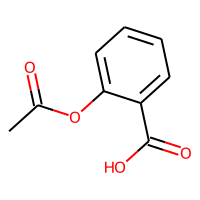

In [ ]:
# Write the SMILES for acetylsalicylic acid and check its 2D-representation
m=Chem.MolFromSmiles('CC(=O)Oc1ccccc1C(=O)O')
Chem.Draw.MolToImage(m, size=(200, 200))

---

**2a)** We now load the toxicity dataset from the TOX21 program (https://github.com/filipsPL/tox21_dataset/tree/master/compounds).

Load the data from the 'sr-are' dataset.

Save the SMILES in the array 'smiles', and the activities in the array 'toxicity'.

In [ ]:
# load the data from the 'sr-are' dataset
datapd = pd.read_csv('https://raw.githubusercontent.com/filipsPL/tox21_dataset/master/compounds/sr-are.tab',sep="\t")
data=datapd.to_numpy()

# define smiles and toxicity
smiles=data[:,1]
toxicity=data[:,2]

**2b)** Check the SMILES and toxicity of the first 5 compounds

In [ ]:
# print out the SMILES of the first 5 compounds

print(smiles[0:5])

['CC(C)=CCC/C(/C)=C/CO' 'OC(=O)CCc1[nH]c2ccccc2[n]1'
 'O=C1Nc2cc(Cl)ccc2N1C1CCN(CCCN2c3ccccc3NC2=O)CC1'
 'Clc1ccccc1-c1[n]c([n]o1)-c1cc[n]cc1'
 'Clc1cc2C(=Nc3ccccc3Oc2cc1)N1CCNCC1']


In [ ]:
# print out the activity of the first 5 compounds

print(toxicity[0:5])

[0 0 0 1 0]


---

In order to make the data usable for a neural network we have to generate a mapping from characters to integers and vice versa.

We first create a sorted list of the characters used in the SMILES of our dataset, stored in 'unique_chars'. We then create a mapping between this list and the integers.

In [ ]:
# list of characters
unique_chars = sorted(list(OrderedDict.fromkeys(chain.from_iterable(smiles))))
# charachter to integer dictionary
char_to_int = dict((c, i) for i, c in enumerate(unique_chars))
# integer to charachter dictionary
int_to_char = dict((i, c) for i, c in enumerate(unique_chars))

**3a)** Check that the dictionary is well-defined. Which integer belongs to 'C'?

In [ ]:
# print out the dictionary

print(char_to_int)

{'#': 0, '(': 1, ')': 2, '+': 3, '-': 4, '/': 5, '1': 6, '2': 7, '3': 8, '4': 9, '5': 10, '6': 11, '7': 12, '8': 13, '9': 14, '=': 15, '@': 16, 'A': 17, 'B': 18, 'C': 19, 'F': 20, 'H': 21, 'I': 22, 'K': 23, 'M': 24, 'N': 25, 'O': 26, 'P': 27, 'S': 28, 'V': 29, 'Z': 30, '[': 31, '\\': 32, ']': 33, 'b': 34, 'c': 35, 'e': 36, 'g': 37, 'i': 38, 'l': 39, 'n': 40, 'o': 41, 'r': 42, 's': 43, 't': 44, 'u': 45}


In [ ]:
# find the integer belonging to 'C'

intC=char_to_int['C']
print('integer belonging to C: ', intC)

integer belonging to C:  19


**3b)** How many unique characters do we have?

In [ ]:
# find the number of unique characters

mapping_size = len(char_to_int)
print ("Size of the character to integer dictionary is: ", mapping_size)

Size of the character to integer dictionary is:  46


---

Now we can encode the SMILES sequences using the dictionary. 

The resulting dimensions of the encoded data array should be (number of SMILES sequences, length of the longest sequence, length of dictionary). 

The last dimension is used as a one-hot-encoding of the respective character. 

For example the indices [11,3,5] correspond to position number 3 of sequence number 11 and to character number 5 in the dictionary: the value in the array is "1" if the character is at this position of the sequence, otherwise "0".

**4a)** First we need the number of SMILES sequences and the length of the longest sequence: 

find and store them in the variables 'n_seq' and 'longest'.

In [ ]:
# number of SMILES sequences

n_seq=smiles.shape[0]
print('number of SMILES sequences: ', n_seq)

number of SMILES sequences:  2188


In [ ]:
# longest SMILES sequence

longest=max([len(seq) for seq in smiles])
print('length of the longest sequence: ', longest)

length of the longest sequence:  321


The following routine returns the encoded data array, as described above.

In [ ]:
# routine to encode the dataset
def gen_data(a,b,c,d,e):
    
    one_hot =  np.zeros((c,d,e),dtype=np.int8)
    for i,smile in enumerate(a):
        #encode the chars
        for j,k in enumerate(smile):
            one_hot[i,j,b[k]] = 1
    return one_hot

**4b)** Use now this routine with appropriate inputs arrays and variables to encode our SMILES dataset.

In [ ]:
# encode the dataset
smiles_enc = gen_data(smiles,char_to_int,n_seq,longest,mapping_size)


**4c)** Check with a couple of random examples that the encoding was done correctly.

In [ ]:
#encoding check

sequence_number=2187
character='C'
print(smiles[sequence_number])
print(smiles_enc[sequence_number,:,char_to_int[character]])

CN1[C@@H]2[C@]3(CCN4CC=C[C@](CC)([C@@H]34)[C@@H](OC(C)=O)[C@]2(O)C(=O)OC)c2cc(c(cc12)OC)[C@]1(C[C@@H]2C[C@](O)(CN(C2)CCc2c1[nH]c1ccccc21)CC)C(=O)OC
[1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 1 1 0 1 0 1 0 0 0 1 1 0 0 0 1 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0
 1 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


---

## Part B: Machine Learning

We are now ready to apply a machine learning approach to our data: a neural network should learn to recognize the toxicity of a molecule by looking at its SMILE sequence.

We first shuffle the dataset to avoid ordering bias and split it in a train and a test set.

In [ ]:
# we shuffle the dataset
X, Y = shuffle(smiles_enc, toxicity)

In [ ]:
# we split the dataset in a train and a test set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=35)

# we convert to float for keras
X_train = X_train.astype(np.float64)
X_test = X_test.astype(np.float64)
y_train = y_train.astype(np.float64)
y_test = y_test.astype(np.float64)

---

As an example, the following code defines, trains and tests a neural network on our dataset. The neural network has dense layers with 5 units, lasts 20 epochs and uses the accuracy of the forecast as measure for the performance.

In [ ]:
# we define the optimizer
opt = tf.keras.optimizers.SGD(learning_rate=0.001)

# we define the model
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(X_train.shape[1], X_train.shape[2])),
    tf.keras.layers.Dense(5, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(5, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# we compile the model
model.compile(optimizer=opt,loss='binary_crossentropy', metrics=['accuracy'])

# we train and test the model 
history_example = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32)

Epoch 1/20
46/46 [==============================] - 1s 15ms/step - loss: 0.6997 - accuracy: 0.5017 - val_loss: 0.7009 - val_accuracy: 0.4786
Epoch 2/20
46/46 [==============================] - 1s 11ms/step - loss: 0.6963 - accuracy: 0.5276 - val_loss: 0.6992 - val_accuracy: 0.4841
Epoch 3/20
46/46 [==============================] - 0s 8ms/step - loss: 0.6956 - accuracy: 0.5085 - val_loss: 0.6978 - val_accuracy: 0.4869
Epoch 4/20
46/46 [==============================] - 0s 7ms/step - loss: 0.6937 - accuracy: 0.5249 - val_loss: 0.6969 - val_accuracy: 0.4855
Epoch 5/20
46/46 [==============================] - 0s 8ms/step - loss: 0.6916 - accuracy: 0.5379 - val_loss: 0.6962 - val_accuracy: 0.4896
Epoch 6/20
46/46 [==============================] - 0s 8ms/step - loss: 0.6915 - accuracy: 0.5427 - val_loss: 0.6955 - val_accuracy: 0.4993
Epoch 7/20
46/46 [==============================] - 0s 7ms/step - loss: 0.6904 - accuracy: 0.5331 - val_loss: 0.6949 - val_accuracy: 0.4993
Epoch 8/20
46/46 [

The optimisation history can be visualized by plotting the accuracy of the train and of the test set as function of the epochs.

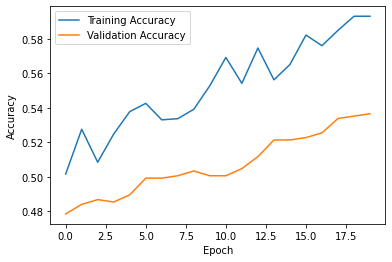

In [ ]:
# we plot of the optimisation history
plt.plot(history_example.history['accuracy'], label='Training Accuracy')
plt.plot(history_example.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

---

**5a)** Now define, compile, train and test a neural network having dense layers with 15 units, lasts 200 epochs and also uses the accuracy of the forecast as measure for the performance.

In [ ]:
# define, compile, train and test the model

# define optimizer
opt = tf.keras.optimizers.SGD(learning_rate=0.001)

# define the model
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(X_train.shape[1], X_train.shape[2])),
    tf.keras.layers.Dense(15, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(15, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# compile the model
model.compile(optimizer=opt,loss='binary_crossentropy', metrics=['accuracy'])

# train and test the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200, batch_size=32)

Epoch 1/200
46/46 [==============================] - 1s 14ms/step - loss: 0.6919 - accuracy: 0.5195 - val_loss: 0.6907 - val_accuracy: 0.5740
Epoch 2/200
46/46 [==============================] - 0s 9ms/step - loss: 0.6916 - accuracy: 0.5154 - val_loss: 0.6906 - val_accuracy: 0.5768
Epoch 3/200
46/46 [==============================] - 0s 8ms/step - loss: 0.6919 - accuracy: 0.5311 - val_loss: 0.6905 - val_accuracy: 0.5878
Epoch 4/200
46/46 [==============================] - 0s 7ms/step - loss: 0.6909 - accuracy: 0.5502 - val_loss: 0.6904 - val_accuracy: 0.5906
Epoch 5/200
46/46 [==============================] - 0s 7ms/step - loss: 0.6915 - accuracy: 0.5229 - val_loss: 0.6903 - val_accuracy: 0.5934
Epoch 6/200
46/46 [==============================] - 0s 7ms/step - loss: 0.6912 - accuracy: 0.5392 - val_loss: 0.6902 - val_accuracy: 0.6017
Epoch 7/200
46/46 [==============================] - 0s 8ms/step - loss: 0.6905 - accuracy: 0.5372 - val_loss: 0.6901 - val_accuracy: 0.5961
Epoch 8/200


**5b)** Plot the optimisation history of this neural network. What can be said about the results?

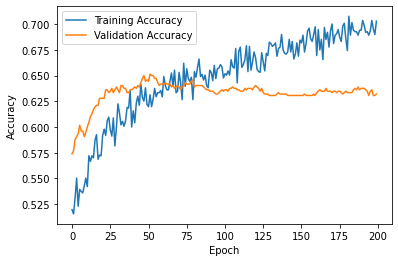

In [ ]:
# plot the optimisation history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Q: What can be said about these results?

A: Looking at the accuracy, the results seem to be not perfect.

---

We try now to improve the results. In a lot of applications the optimization of the accuracy might be the wrong goal. For example, predicting a non-toxic molecule as toxic is not equally worse than predicting a toxic one as non-toxic. Therefore, we have to consider alternative metrics:

**What are Sensitivity and Specificity?**

* Sensitivity / True Positive Rate (TPR) 

 Sensitivity tells us what proportion of the positive class got correctly classified. A simple example would be to determine what proportion of the actual toxic molecules were correctly detected by the model.

* False Negative Rate (FNR)

 False Negative Rate (FNR) tells us what proportion of the positive class got incorrectly classified by the classifier. A higher TPR and a lower FNR is desirable since we want to correctly classify the positive class.

* Specificity / True Negative Rate (TNR)

 Specificity tells us what proportion of the negative class got correctly classified. Taking the same example as in Sensitivity, Specificity would mean determining the proportion of non-toxic molecules who were correctly identified by the model.

* False Positive Rate (FPR)

 FPR tells us what proportion of the negative class got incorrectly classified by the classifier. A higher TNR and a lower FPR is desirable since we want to correctly classify the non-toxic class.

**How can we combine these quantities best?**

The Receiver Operator Characteristic (ROC) curve is an evaluation metric for binary classification problems. It is a probability curve that plots the TPR against FPR at various threshold values and essentially separates the "signal" from the "noise". The Area Under the Curve (AUC) is the measure of the ability of a classifier to distinguish between classes and is used as a summary of the ROC curve.

The higher the AUC, the better the performance of the model at distinguishing between the positive and negative classes. A random oracle has AUC = 0.5.

---

We first calculate the metrics for predictions on the test set.

In [ ]:
# we calculate metrics for predictions on test set
y_pred = (model.predict(X_test) > 0.5).astype(int)

CM = confusion_matrix(y_pred,y_test)

TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]

# Sensitivity or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

---

**6a)** Define, train and test a neural network having dense layers with 15 units, lasts 200 epochs but now uses the AUC as measure for the performance.

In [ ]:
# define, train and test the model

# define optimizer
opt = tf.keras.optimizers.SGD(learning_rate=0.001)


# define the model
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(X_train.shape[1], X_train.shape[2])),
    tf.keras.layers.Dense(15, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(15, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# we compile the model
model.compile(optimizer=opt,loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(from_logits=True)])

# train and test the model
history_2 = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200, batch_size=32)

Epoch 1/200
46/46 [==============================] - 2s 19ms/step - loss: 0.6936 - auc: 0.5075 - val_loss: 0.6923 - val_auc: 0.5338
Epoch 2/200
46/46 [==============================] - 1s 12ms/step - loss: 0.6923 - auc: 0.5263 - val_loss: 0.6922 - val_auc: 0.5340
Epoch 3/200
46/46 [==============================] - 1s 12ms/step - loss: 0.6910 - auc: 0.5499 - val_loss: 0.6920 - val_auc: 0.5419
Epoch 4/200
46/46 [==============================] - 1s 12ms/step - loss: 0.6927 - auc: 0.5243 - val_loss: 0.6918 - val_auc: 0.5499
Epoch 5/200
46/46 [==============================] - 1s 12ms/step - loss: 0.6922 - auc: 0.5332 - val_loss: 0.6916 - val_auc: 0.5581
Epoch 6/200
46/46 [==============================] - 0s 10ms/step - loss: 0.6928 - auc: 0.5148 - val_loss: 0.6915 - val_auc: 0.5648
Epoch 7/200
46/46 [==============================] - 0s 9ms/step - loss: 0.6909 - auc: 0.5546 - val_loss: 0.6912 - val_auc: 0.5701
Epoch 8/200
46/46 [==============================] - 0s 7ms/step - loss: 0.69

**6b)** Plot the optimisation history of this neural network. Are the results better?

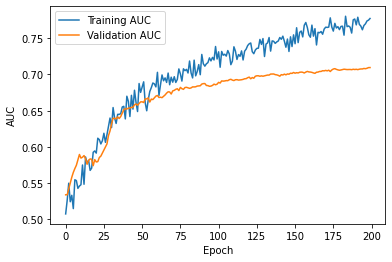

In [ ]:
# plot the optimisation history
plt.plot(history_2.history['auc'], label='Training AUC')
plt.plot(history_2.history['val_auc'], label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.show()

---

The neural networks used above do not seem to perform well. We try an approach with a Long Short-Term Memory network (LSTM).

**7)** Play around with the parameters of the LSTM model and try to improve the performance.

In [ ]:
# LSTM model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM, Bidirectional
from keras.layers.embeddings import Embedding

model = Sequential()
model.add(Bidirectional(LSTM(10, return_sequences=True), input_shape=(longest, mapping_size)))
model.add(tf.keras.layers.Flatten(input_shape=(longest, 20)))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.AUC(from_logits=True)])
print(model.summary())
history_lstm = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=28)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_5 (Bidirectio  (None, 321, 20)          4560      
 nal)                                                            
                                                                 
 flatten_8 (Flatten)         (None, 6420)              0         
                                                                 
 dense_19 (Dense)            (None, 10)                64210     
                                                                 
 dense_20 (Dense)            (None, 1)                 11        
                                                                 
Total params: 68,781
Trainable params: 68,781
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
53/53 [==============================] - 23s 284ms/step - loss: 0.6665 - auc_6: 0.6449 - val_loss: 0

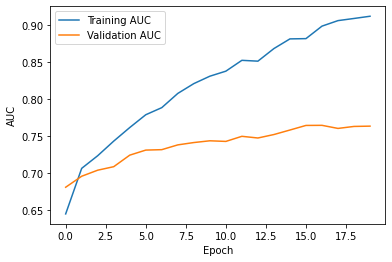

In [ ]:
# plot of the optimisation history
plt.plot(history_lstm.history['auc_6'], label='Training AUC')
plt.plot(history_lstm.history['val_auc_6'], label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.show()